In [1]:
import torch
import torch.nn as nn

In [2]:
from importlib.metadata import version
pkg = [
        "matplotlib",
        "numpy",
        "tiktoken",
        "torch",
]

for i in pkg:
    print(f'{i}  with version:{version(i)}')

matplotlib  with version:3.9.1
numpy  with version:1.26.4
tiktoken  with version:0.8.0
torch  with version:2.4.0


In [3]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,    # Vocabulary size
    "context_length": 256, # Context length
    "emb_dim": 768,         # Embedding dimension
    "n_heads": 12,          # Number of attention heads
    "n_layers": 12,         # Number of layers
    "drop_rate": 0.1,       # Dropout rate
    "qkv_bias": False       # Query-Key-Value bias
}

In [4]:
from previous_chapters import GPTModel

In [5]:
model = GPTModel(GPT_CONFIG_124M)

In [6]:
import tiktoken
from previous_chapters import generate_text_simple

# Alternatively:
# from llms_from_scratch.ch04 import generate_text_simple

def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # add batch dimension
    return encoded_tensor

def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # remove batch dimension
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output text:\n", token_ids_to_text(token_ids, tokenizer))

Output text:
 Every effort moves youcrim critiques herebylowADD commissionurasigue Joan foundations


In [8]:
import os
import urllib.request

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    with urllib.request.urlopen(url) as response:
        text_data = response.read().decode('utf-8')
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

In [9]:
text_data[-99:]

'it for me! The Strouds stand alone, and happen once--but there\'s no exterminating our kind of art."'

In [10]:
test_split = 0.90
split_point = int(test_split * len(text_data))
train_text = text_data[:split_point]
val_text = text_data[split_point:]
print(len(train_text))
print(len(val_text))

18431
2048


In [11]:
from previous_chapters import create_dataloader_v1

train_loader = create_dataloader_v1(
    train_text,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_text,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

apparently nn.functional.cross_entropy can calculate all the needed things under the hood.
getting the token value and go to the prediction, and search for that index and getting the
assign probability and do -log(prob) , and you see flattening targets  it turn like
[1,23,4 ....] , model output [batch , seq_len , vocabulary] --> [batch * seq_len , vocabulary]
so like all seq with its prediction for each vocabulary.

In [12]:
def batch_loss(train_batch,labels_batch,model,device):
    train_batch,labels_batch = train_batch.to(device),labels_batch.to(device)
    pred = model(train_batch)
    loss = nn.functional.cross_entropy(pred.flatten(0,1),labels_batch.flatten())
    return loss

def full_loss(data_loader,model,device,num_batch = None):
    full_loss = 0

    if len(data_loader) == 0:
        return float("nan")
    elif  num_batch is None:
        num_batch = len(data_loader)
    else:
        for i,data in enumerate(data_loader):
            if i < num_batch:
                loss = batch_loss(data[0],data[1],model,device)
                full_loss += loss
            else:
                break
    return full_loss / num_batch


In [18]:
def evaluate_model(model, train_loader, val_loader, device, eval_count):
    model.eval()
    with torch.no_grad():
        train_loss = full_loss(train_loader, model, device, num_batch=eval_count)
        val_loss = full_loss(val_loader, model, device, num_batch=eval_count)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))
    model.train()

In [25]:
def train_model(model,train_loader,val_loader,optimizer,device,epoch,val_frequency,
                eval_count,context,tokenizer):
    train_losses, validation_losses,track_token_count = [],[],[]
    tokens_seen, global_epoc = 0,-1

    for epoc in range(epoch):
        model.train()
        for data,labels in train_loader:
            loss = batch_loss(data,labels,model,device)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tokens_seen += data.numel()
            global_epoc += 1

            if global_epoc % val_frequency == 0:
                    train_loss, val_loss = evaluate_model(
                        model, train_loader, val_loader, device, eval_count)
                    train_losses.append(train_loss)
                    validation_losses.append(val_loss)
                    track_token_count.append(tokens_seen)
                    print(f"Ep {epoc+1} (Step {global_epoc:06d}): "
                          f"Train loss {train_loss:.3f}, Val loss {val_loss:.3f}")

        generate_and_print_sample(
            model, tokenizer, device, context
        )

    return train_losses, val_losses, track_token_count


In [26]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model(
    model, train_loader, val_loader, optimizer, device,epoch=num_epochs,eval_count=5,
    val_frequency=5,context="Every effort moves you",tokenizer = tokenizer)

Ep 1 (Step 000000): Train loss 9.821, Val loss 1.999
Ep 1 (Step 000005): Train loss 8.084, Val loss 1.641
Every effort moves you the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
Ep 2 (Step 000010): Train loss 6.769, Val loss 1.414
Ep 2 (Step 000015): Train loss 6.024, Val loss 1.317
Every effort moves you, the,, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the, the,
Ep 3 (Step 000020): Train loss 9.899, Val loss 2.281
Ep 3 (Step 000025): Train loss 5.701, Val loss 1.299
Every effort moves you, I                                                
Ep 4 (Step 000030): Train loss 5.309, Val loss 1.291
Ep 4 (Step 000035): Train loss 5.562, Val loss 1.340
Every effort moves you, I, I had the, the, the, the, the of the of the of the of the of the of the of the of the of the of the of the.

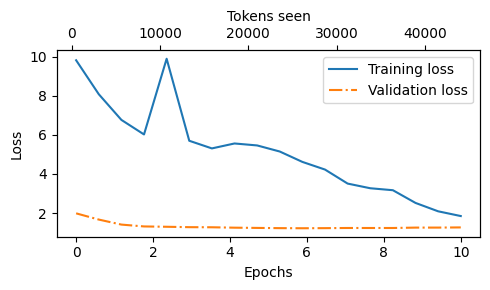

In [27]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # Plot training and validation loss against epochs
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # Create a second x-axis for tokens seen
    ax2 = ax1.twiny()  # Create a second x-axis that shares the same y-axis
    ax2.plot(tokens_seen, train_losses, alpha=0)  # Invisible plot for aligning ticks
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()  # Adjust layout to make room
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

In [28]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        if top_k is not None:
            # Keep only top_k values
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        if temperature > 0.0:
            logits = logits / temperature

            probs = torch.softmax(logits, dim=-1)

            idx_next = torch.multinomial(probs, num_samples=1)

        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)

        if idx_next == eos_id:
            break

        idx = torch.cat((idx, idx_next), dim=1)

    return idx

In [31]:
torch.save(model.state_dict(),"D:\ML Projects\LLM-From-Scratch\model\model.pth")